### Stochastic volatility 

At first we import a few common packages

In [1]:
import time
import os

import numpy as np
import scipy
import scipy.stats
from scipy.stats import multivariate_normal
from pandas import MultiIndex
import matplotlib.pyplot as plt

Now we set the number of threads to be used by `Kokkos` and import `MParT`.

In [2]:
os.environ['KOKKOS_NUM_THREADS'] = '8'
from mpart import *

print('Kokkos is using', Concurrency(), 'threads')


Kokkos is usingKokkos::OpenMP::initialize WARNING: OMP_PROC_BIND environment variable not set
  In general, for best performance with OpenMP 4.0 or better set OMP_PROC_BIND=spread and OMP_PLACES=threads
  For best performance with OpenMP 3.1 set OMP_PROC_BIND=true
  For unit testing set OMP_PROC_BIND=false
Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   2,  requested thread :   8
 8 threads


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 2 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


In [3]:
T = 40 #number of time steps
d = T+2

In [4]:
opts = MapOptions()
opts.basisType = BasisTypes.HermiteFunctions

Let's generate some training and test samples and calculate the true log-pdf.

In [5]:
def generate_SV_samples(d,N):
    # Sample hyper-parameters
    sigma = 0.25
    mu = np.random.randn(1,N)
    phis = 3+np.random.randn(1,N)
    phi = 2*np.exp(phis)/(1+np.exp(phis))-1
    X = np.vstack((mu,phi))
    if d > 2:
        # Sample Z0
        Z = np.sqrt(1/(1-phi**2))*np.random.randn(1,N) + mu

        # Sample auto-regressively
        for i in range(d-3):
            Zi = mu + phi * (Z[-1,:] - mu)+sigma*np.random.randn(1,N)
            Z = np.vstack((Z,Zi))

        X = np.vstack((X,Z))
    return X

def SV_log_pdf(X):
    
    def normpdf(x,mu,sigma):
        return  np.exp(-0.5 * ((x - mu)/sigma)**2) / (np.sqrt(2*np.pi) * sigma);
    
    sigma = 0.25

    # Extract variables mu, phi and states
    mu = X[0,:]
    phi = X[1,:]
    Z = X[2:,:]

    # Compute density for mu
    piMu = multivariate_normal(np.zeros(1),np.eye(1))
    logPdfMu = piMu.logpdf(mu)
    # Compute density for phi
    phiRef = np.log((1+phi)/(1-phi))
    dphiRef = 2/(1-phi**2)
    piPhi = multivariate_normal(3*np.ones(1),np.eye(1))
    logPdfPhi = piPhi.logpdf(phiRef)+np.log(dphiRef)
    # Add piMu, piPhi to density
    logPdf = np.vstack((logPdfMu,logPdfPhi))

    # Number of time steps
    dz = Z.shape[0]
    if dz > 0:
        # Conditonal density for Z_0
        muZ0 = mu
        stdZ0 = np.sqrt(1/(1-phi**2))
        logPdfZ0 = np.log(normpdf(Z[0,:],muZ0,stdZ0))
        logPdf = np.vstack((logPdf,logPdfZ0))

        # Compute auto-regressive conditional densities for Z_i|Z_{1:i-1}
        for i in range(1,dz):
            meanZi = mu + phi * (Z[i-1,:]-mu)
            stdZi = sigma
            logPdfZi = np.log(normpdf(Z[i,:],meanZi,stdZi))
            logPdf = np.vstack((logPdf,logPdfZi))
    return logPdf

N = 2000 #Number of training samples
X = generate_SV_samples(d, N)

Ntest = 2000 # Number of testing samples
Xtest = generate_SV_samples(d,Ntest)
logPdfSV = SV_log_pdf(Xtest) # true log-pdf

That's how a few realizations of the process look like

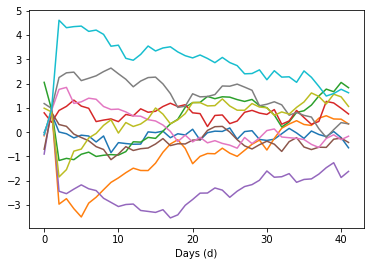

In [6]:
plt.plot(X[:,0:10]);
plt.xlabel("Days (d)");

In [7]:
### Negative log likelihood objective
def obj(coeffs, tri_map,x):
    """ Evaluates the log-likelihood of the samples using the map-induced density. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Compute the map-induced density at each point 
    map_of_x = tri_map.Evaluate(x)

    rho = multivariate_normal(np.zeros(tri_map.outputDim),np.eye(tri_map.outputDim))
    rho_of_map_of_x = rho.logpdf(map_of_x.T)
    log_det = tri_map.LogDeterminant(x)

    # Return the negative log-likelihood of the entire dataset
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    """ Returns the gradient of the log-likelihood objective wrt the map parameters. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = tri_map.Evaluate(x)

    # Now compute the inner product of the map jacobian (\nabla_w S) and the gradient (which is just -S(x) here)
    grad_rho_of_map_of_x = -tri_map.CoeffGrad(x, map_of_x)

    # Get the gradient of the log determinant with respect to the map coefficients
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points


def log_cond_pullback_pdf(triMap,rho,x):
    r = triMap.Evaluate(x)
    log_pdf = rho.logpdf(r.T)+triMap.LogDeterminant(x)
    return log_pdf

def compute_joint_KL(logPdfSV,logPdfTM):
    KL = np.zeros((logPdfSV.shape[0],))
    for k in range(1,d+1):
        KL[k-1]=np.mean(np.sum(logPdfSV[:k,:],0)-np.sum(logPdfTM[:k,:],0))
    return KL

In [8]:
# Total order 1 approximation
totalOrder = 1;
logPdfTM = np.zeros((Ntest,))
ListCoeffs_to1=[];
for dk in range(1,d+1):
    fixed_mset= FixedMultiIndexSet(dk,totalOrder)
    S = CreateComponent(fixed_mset,opts)
    Xtrain = X[:dk,:]
    Xtestk = Xtest[:dk,:]

    print("Number of coefficients: "+str(S.numCoeffs))
    ListCoeffs_to1.append(S.numCoeffs)

    options={'gtol': 1e-3, 'disp': True}
    res = scipy.optimize.minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    rho = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))
    logPdfTM=np.vstack((logPdfTM,log_cond_pullback_pdf(S,rho,Xtestk)))
    xplot = np.linspace(-0.5,1.5,200).reshape(1,-1)
logPdfTM_to1=logPdfTM[1:,:]

# Compute joint KL divergence
KL_to1 = compute_joint_KL(logPdfSV,logPdfTM_to1)

Number of coefficients: 2
Optimization terminated successfully.
         Current function value: 1.437029
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Number of coefficients: 3
Optimization terminated successfully.
         Current function value: -0.539296
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Number of coefficients: 4
Optimization terminated successfully.
         Current function value: 2.474967
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Number of coefficients: 5
Optimization terminated successfully.
         Current function value: 0.329789
         Iterations: 14
         Function evaluations: 19
         Gradient evaluations: 19
Number of coefficients: 6
Optimization terminated successfully.
         Current function value: 0.171466
         Iterations: 27
         Function evaluations: 32
         Gradient evaluations: 32
Number of co

In [9]:
# Total order 2 approximation
totalOrder = 2;
logPdfTM = np.zeros((Ntest,))
ListCoeffs_to2=[];
for dk in range(1,d+1):
    print(dk)
    fixed_mset= FixedMultiIndexSet(dk,totalOrder)
    S = CreateComponent(fixed_mset,opts)
    Xtrain = X[:dk,:]
    Xtestk = Xtest[:dk,:]
    
    print("Number of coefficients: "+str(S.numCoeffs))
    ListCoeffs_to2.append(S.numCoeffs)

    options={'gtol': 1e-3, 'disp': True}
    res = scipy.optimize.minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    rho = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))    
    logPdfTM=np.vstack((logPdfTM,log_cond_pullback_pdf(S,rho,Xtestk)))
logPdfTM_to2=logPdfTM[1:,:]

# Compute joint KL divergence
KL_to2 = compute_joint_KL(logPdfSV,logPdfTM_to2)

1
Number of coefficients: 3
Optimization terminated successfully.
         Current function value: 1.436825
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
2
Number of coefficients: 6
Optimization terminated successfully.
         Current function value: -0.805699
         Iterations: 42
         Function evaluations: 46
         Gradient evaluations: 46
3
Number of coefficients: 10
Optimization terminated successfully.
         Current function value: 2.380399
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
4
Number of coefficients: 15
Optimization terminated successfully.
         Current function value: 0.024917
         Iterations: 60
         Function evaluations: 68
         Gradient evaluations: 68
5
Number of coefficients: 21
Optimization terminated successfully.
         Current function value: 0.027405
         Iterations: 85
         Function evaluations: 91
         Gradient evaluations: 91

In [10]:
# Problem specifc MultiIndexSet:
#   - First and last 2 variables of each component (for component 1 and 3 that's for all variables) are represented by a total order 2 MultiIndexSet
#   - Second component is computed with high order polynomial w.r.t second variable

totalOrder = 2;
logPdfTM = np.zeros((Ntest,))
ListCoeffs_sa=[];
mset_to= MultiIndexSet.CreateTotalOrder(4,totalOrder,NoneLim())

maxOrder=9
for dk in range(1,d+1):
    print(dk)
    if dk == 1:
        fixed_mset= FixedMultiIndexSet(1,totalOrder)
        S = CreateComponent(fixed_mset,opts)
        Xtrain = X[dk-1,:].reshape(1,-1)
        Xtestk = Xtest[dk-1,:].reshape(1,-1)
    elif dk == 2:
        fixed_mset= FixedMultiIndexSet(1,maxOrder)
        S = CreateComponent(fixed_mset,opts)
        Xtrain = X[dk-1,:].reshape(1,-1)
        Xtestk = Xtest[dk-1,:].reshape(1,-1) 
    elif dk==3:
        fixed_mset= FixedMultiIndexSet(dk,totalOrder)
        S = CreateComponent(fixed_mset,opts)
        Xtrain = X[:dk,:]
        Xtestk = Xtest[:dk,:]
    else:
        multis=np.zeros((mset_to.Size(),dk))
        for s in range(mset_to.Size()):
            multis_to = np.array([mset_to[s].tolist()])
            multis[s,:2]=multis_to[0,:2]
            multis[s,-2:]=multis_to[0,-2:]
        mset = MultiIndexSet(multis)
        fixed_mset = mset.fix(True)
        S = CreateComponent(fixed_mset,opts)
        Xtrain = X[:dk,:]
        Xtestk = Xtest[:dk,:]

    print("Number of coefficients: "+str(S.numCoeffs))
    ListCoeffs_sa.append(S.numCoeffs)

    options={'gtol': 1e-3, 'disp': True}
    res = scipy.optimize.minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    rho = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))    
    logPdfTM=np.vstack((logPdfTM,log_cond_pullback_pdf(S,rho,Xtestk)))
logPdfTM_sa=logPdfTM[1:,:]

# Compute joint KL divergence
KL_sa = compute_joint_KL(logPdfSV,logPdfTM_sa)

1
Number of coefficients: 3
Optimization terminated successfully.
         Current function value: 1.436825
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
2
Number of coefficients: 10
Optimization terminated successfully.
         Current function value: -1.027281
         Iterations: 70
         Function evaluations: 79
         Gradient evaluations: 79
3
Number of coefficients: 10
Optimization terminated successfully.
         Current function value: 2.380399
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
4
Number of coefficients: 15
Optimization terminated successfully.
         Current function value: 0.024917
         Iterations: 60
         Function evaluations: 68
         Gradient evaluations: 68
5
Number of coefficients: 15
Optimization terminated successfully.
         Current function value: 0.029450
         Iterations: 63
         Function evaluations: 70
         Gradient evaluations: 7

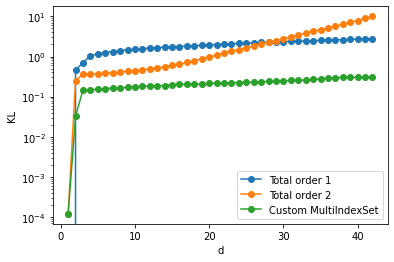

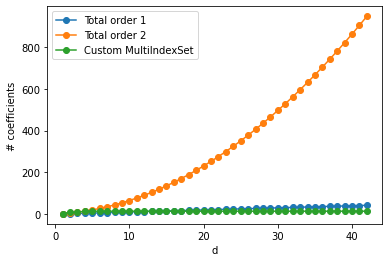

In [11]:
# Compare map approximations 
fig, ax = plt.subplots()
ax.plot(range(1,d+1),KL_to1,'-o',label='Total order 1')
ax.plot(range(1,d+1),KL_to2,'-o',label='Total order 2')
ax.plot(range(1,d+1),KL_sa,'-o',label='Custom MultiIndexSet')
ax.set_yscale('log')
ax.set_xlabel('d')
ax.set_ylabel('KL')
plt.legend()
plt.show()

# Increasing the total order of the approximation should improve the quality of approximation. 
# However, at a certain number of dimension the number of coefficients to optimize is too large compare to the number of samples.
# That's why using a custom MultiIndexSet that exploits sparsity of the problem helps solving this problem
fig, ax =plt.subplots()
ax.plot(range(1,d+1),ListCoeffs_to1,'-o',label='Total order 1')
ax.plot(range(1,d+1),ListCoeffs_to2,'-o',label='Total order 2')
ax.plot(range(1,d+1),ListCoeffs_sa,'-o',label='Custom MultiIndexSet')
ax.set_xlabel('d')
ax.set_ylabel('# coefficients')
plt.legend()
plt.show()